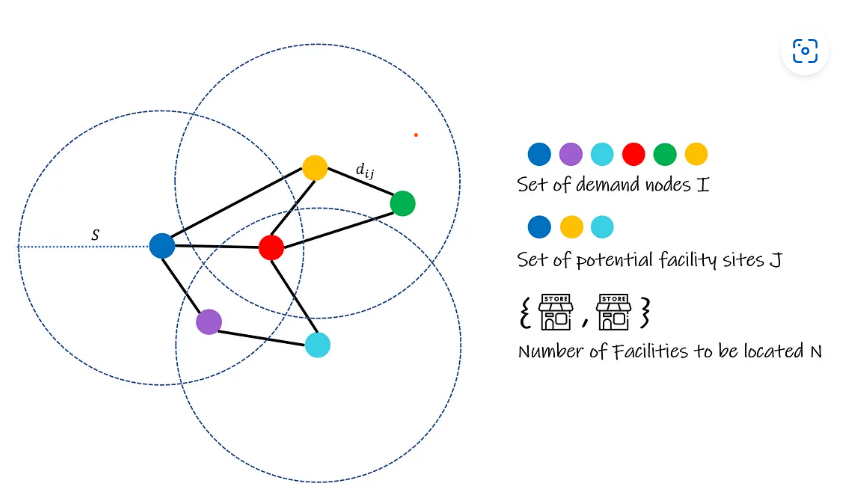

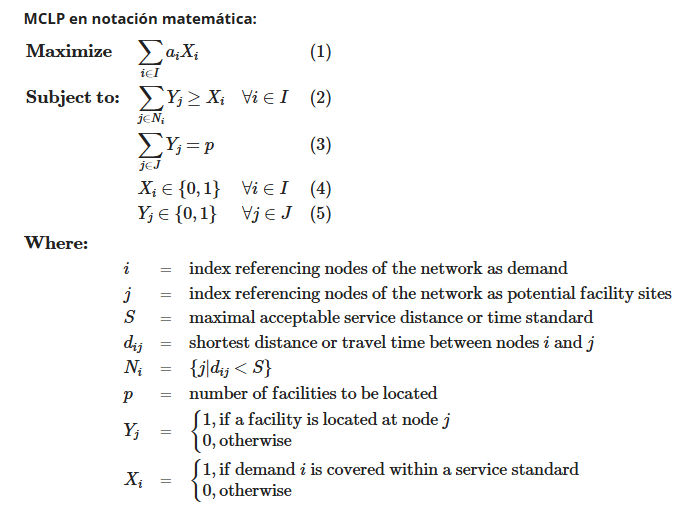

In [1]:
import pandas as pd 
import numpy as np
import qiskit

In [2]:
from numpy.linalg import norm

def eucledian_distance(A: np.ndarray, B: np.ndarray) -> np.ndarray:
    A, B = np.array(A), np.array(B)
    sum = np.sum(np.square(A-B))
    return np.sqrt(sum)

In [3]:
df = pd.read_excel('instance_mclp.xlsx')
df

,name,s,p,row,col,0,1,2,3,4,5,6,7,8
0,ex_1,1,2,3,3,x0,NaN,x2,NaN,NaN,NaN,x6,NaN,NaN
1,ex_1,1,2,3,3,4,5.0,2,2.0,1.0,4.0,2,2.0,1.0


In [4]:
#field
rows: int = df.iloc[0]['row']
cols: int = df.iloc[0]['col']
#Number of facilities
p: int = df.iloc[0]['p']
#service distance
S: int = df.iloc[0]['s']

#Set of demand nodes
I = range(rows*cols)
#Set of potential facilities sites map
J: list[int] = [ 1 if str(df.iloc[0][j]) != 'nan' else 0 
    for j in I
]
#population to each node
pop = [int(df.iloc[1][j]) for j in I]

print(f"{p} facilities to place.")
print(f"Service distance is {S}.")
print(f"Map has {rows} rows and {cols} columns, for a total {len(I)} nodes.")
print("Potential facility map: ", J)
print("Population at each node: ", pop)


2 facilities to place.
Service distance is 1.
Map has 3 rows and 3 columns, for a total 9 nodes.
Potential facility map:  [1, 0, 1, 0, 0, 0, 1, 0, 0]
Population at each node:  [4, 5, 2, 2, 1, 4, 2, 2, 1]


In [5]:
def get_neighbors(rows: int, cols: int, J: list[int], S: int):
    sites: dict = {}
    counter: int = 0
    #solve coords
    for x in range(rows):
        for y in range(cols):
            sites[counter] = np.array([x,y]) # coord
            counter += 1 # next node

    facilities: int = [ facility for facility, available in enumerate(J) if available == 1]
    # Set of potencial facility sites that would cover node i
    Neighbors: dict = {}
    for i in range(rows* cols):
        for j in  facilities:
            distance: float = eucledian_distance(sites[i], sites[j])
            if distance <= S:
                try:
                    Neighbors[i].append(j)
                except:
                    Neighbors[i] = [j]
            
    return Neighbors

In [6]:
get_neighbors(rows, cols, J, S)

{0: [0], 1: [0, 2], 2: [2], 3: [0, 6], 5: [2], 6: [6], 7: [6]}

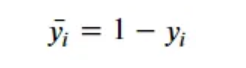

yᵢ equals 1 when there is a facility covering the demand node i, and is 0 otherwise.

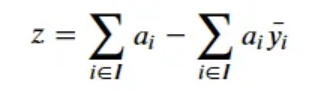

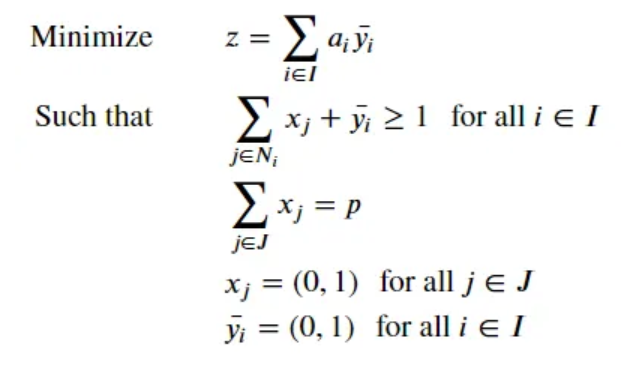

In [7]:
import gurobipy as gp 
from gurobipy import GRB

In [8]:
m = gp.Model("MCLPmin")

## add variables
# Add y_i
y = {}
for i in I:
    y[i] = m.addVar(vtype= GRB.BINARY, name="y_"+str(i))

# Add x_j
x = {}
# go through the list to get indices of potential facility sites
facilities: int = [ facility for facility, available in enumerate(J) if available == 1]
for j in facilities:
    x[j] = m.addVar(vtype= GRB.BINARY, name="x_"+str(j))

m.update()

## Add equations

# Add Objetive function
objective_function = np.sum([pop[i] * y[i] for i in I])
m.setObjective(objective_function, GRB.MINIMIZE)

# Add Constraints 1
N = get_neighbors(rows, cols, J, S)

for i in I:
    temp = []
    if i in N.keys():
        for j in N[i]:
            temp.append(x[j])
        if len(temp) >= 1:
            constraint = np.sum(temp)+ y[i] >= 1
            m.addConstr(constraint, "c1a_"+str(i))
        else:
            m.addConstr(y[i] >= 1, "c1b_"+str(i))

# Add Constraints 2
temp = []
for j in facilities:
    temp.append(x[j])
m.addConstr(np.sum(temp) == p, "c2_"+str(i))


m.update()
## Save .lp file with model
m.write("example_min_mclp.lp")
with open("example_min_mclp.lp", "r") as f:
    print(f.read())



Restricted license - for non-production use only - expires 2025-11-24
\ Model MCLPmin
\ LP format - for model browsing. Use MPS format to capture full model detail.
Minimize
  4 y_0 + 5 y_1 + 2 y_2 + 2 y_3 + y_4 + 4 y_5 + 2 y_6 + 2 y_7 + y_8
Subject To
 c1a_0: y_0 + x_0 >= 1
 c1a_1: y_1 + x_0 + x_2 >= 1
 c1a_2: y_2 + x_2 >= 1
 c1a_3: y_3 + x_0 + x_6 >= 1
 c1a_5: y_5 + x_2 >= 1
 c1a_6: y_6 + x_6 >= 1
 c1a_7: y_7 + x_6 >= 1
 c2_8: x_0 + x_2 + x_6 = 2
Bounds
Binaries
 y_0 y_1 y_2 y_3 y_4 y_5 y_6 y_7 y_8 x_0 x_2 x_6
End



In [9]:
m.setParam('IntFeasTol', 1e-5) # tolerance to non-integer solutions
m.params.timeLimit = 1800
m.optimize()

Set parameter TimeLimit to value 1800
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (win64 - Windows 11.0 (22631.2))

CPU model: AMD Ryzen 7 5700G with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 8 rows, 12 columns and 19 nonzeros
Model fingerprint: 0x3ecd19b0
Variable types: 0 continuous, 12 integer (12 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 5e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+00]
Found heuristic solution: objective 4.0000000
Presolve removed 8 rows and 12 columns
Presolve time: 0.01s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.02 seconds (0.00 work units)
Thread count was 1 (of 16 available processors)

Solution count 1: 4 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.000000000000e+00, best bound 4.000000000000e+00, gap 0.0000%


In [10]:
print(x)

{0: <gurobi.Var x_0 (value 0.0)>, 2: <gurobi.Var x_2 (value 1.0)>, 6: <gurobi.Var x_6 (value 1.0)>}


In [11]:
from qiskit_optimization.converters import InequalityToEquality
from qiskit_optimization.converters import IntegerToBinary
from qiskit_optimization.converters import LinearEqualityToPenalty
from qiskit_optimization.problems import QuadraticProgram
qp            = QuadraticProgram()
iq_to_eq      = InequalityToEquality()
lin_eq_to_pen = LinearEqualityToPenalty()
int_to_bin    = IntegerToBinary()
# load problem with constraints
qp.read_from_lp_file("example_min_mclp.lp")
# convert inequalities into equalities
qp = iq_to_eq.convert(qp)
# remove equality constraints
qp = lin_eq_to_pen.convert(qp)
# convert introduced variables into binary
qp = int_to_bin.convert(qp)
qp.name = "example_min_mclp_qubo"

# Replace variables with @ and save to new file
txt = qp.export_as_lp_string()
txt = txt.replace("@","_")
with open("example_min_mclp_qubo.lp", "w") as f:
    f.write(txt)
    f.close()
    
# Create new variable with QUBO problem
qubo = QuadraticProgram()
qubo.read_from_lp_file("example_min_mclp_qubo.lp")
print(qubo.export_as_lp_string())

MissingOptionalLibraryError: "The 'CPLEX' library is required to use 'QuadraticProgram.read_from_lp_file'. You can install it with 'pip install 'qiskit-optimization[cplex]''."

In [ ]:
pip install 'qiskit-optimization[cplex]'

Note: you may need to restart the kernel to use updated packages.


ERROR: Invalid requirement: "'qiskit-optimization[cplex]'"


In [ ]:
import cplex